# Train/test split

Here we will perform the initial train/test split of the image tiles based on image descriptors computed using [detectree](https://github.com/martibosch/detectree). We will also use the [manually-annotated cantonal tree inventory of Geneva](https://sitg.ge.ch/donnees/sipv-ica-web-public-tot) to explore occurence of confier and deciduous trees.

In [ ]:
from os import path

import detectree as dtr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio import plot
from shapely import geometry

figwidth, figheight = plt.rcParams["figure.figsize"]
random_seed = 20
np.random.seed(random_seed)


def plot_tile_and_trees(ax, img_filepath, trees_gdf, **plot_kwargs):
    """Plot the tile and the trees on top of it."""
    # img = plt.imread(img_filepath)
    with rio.open(img_filepath) as src:
        plot.show(src, ax=ax)
        bounds_geom = geometry.box(*src.bounds)
        trees_gdf[trees_gdf["geometry"].apply(lambda g: g.within(bounds_geom))].plot(
            ax=ax, **plot_kwargs
        )
    ax.axis("off")
    return ax

/home/martibosch/mambaforge/envs/swiss-urban-trees/lib/python3.12/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
tile_gdf_filepath = "../data/raw/sitg-orthophoto-2019-tiles/tiles.gpkg"
tile_dir = "../data/raw/sitg-orthophoto-2019-tiles"

tree_gdf_filepath = "../data/raw/ica-trees.gpkg"

dst_filepath = "../data/raw/sitg-orthophoto-2019-tiles/split.csv"

# split args
train_prop = 0.005
method = "cluster-I"
# n_components = 35
target_evr = 0.9
max_components = 50
n_clusters = 4
n_plots_per_cluster = 5

## Load the datasets

In [ ]:
tiles_gdf = gpd.read_file(tile_gdf_filepath)
tiles_gdf.head()

,tile_filename,geometry
0,2500724.7_1114843.6_2500974.7_1115093.6.tif,"POLYGON ((2500974.652 1114843.585, 2500974.652..."
1,2500974.7_1114843.6_2501224.7_1115093.6.tif,"POLYGON ((2501224.652 1114843.585, 2501224.652..."
2,2501224.7_1114843.6_2501474.7_1115093.6.tif,"POLYGON ((2501474.652 1114843.585, 2501474.652..."
3,2500724.7_1115093.6_2500974.7_1115343.6.tif,"POLYGON ((2500974.652 1115093.585, 2500974.652..."
4,2500974.7_1115093.6_2501224.7_1115343.6.tif,"POLYGON ((2501224.652 1115093.585, 2501224.652..."


In [ ]:
# there is no need to convert the CRS since it is the same for both
trees_gdf = gpd.read_file(tree_gdf_filepath)  # .to_crs(tiles_gdf.crs)
# let us first filter out trees planted after the image acquisition date
trees_gdf = trees_gdf[pd.to_datetime(trees_gdf["DATE_OBSERVATION"]).dt.year <= 2019]
trees_gdf.head()

,gml_id,OBJECTID,NOM_COMPLET,DATE_OBSERVATION,ID_ACTEUR,CLASSE,SOUCHE,STATUT,ID_ARBRE,globalid,...,DIAMETRE_1M,HAUTEUR_TRONC,HAUTEUR_TOTALE,CONDUITE,TYPE_SOL,TYPE_SURFACE,DATE_PLANTATION,DATE_PLANTATION_ESTIMEE,REMARQUABLE,geometry
0,SIPV_ICA_ARBRE_ISOLE.21971,21971,Populus,1976-06-06T00:00:00,Commission de dendrologie,Feuillus,Non,Historique,39866.0,{23703641-22D7-4054-8C8D-89EAC2AF8726},...,NaN,NaN,NaN,None,None,None,None,NaN,None,POINT (2500857.18 1115022.06)
1,SIPV_ICA_ARBRE_ISOLE.22437,22437,Juglans,1976-06-06T00:00:00,Commission de dendrologie,Feuillus,Non,Historique,29113.0,{FABD3159-AE8E-4DE2-A944-28FE609474D4},...,NaN,NaN,NaN,None,None,None,None,NaN,None,POINT (2500731.89 1114886.83)
2,SIPV_ICA_ARBRE_ISOLE.27777,27777,Juglans,1976-06-06T00:00:00,Commission de dendrologie,Feuillus,Non,Historique,40090.0,{95D069F0-27F2-431A-A6FB-04E52F816669},...,NaN,NaN,NaN,None,None,None,None,NaN,None,POINT (2500700.78 1114855.2)
3,SIPV_ICA_ARBRE_ISOLE.46336,46336,Populus,1976-06-06T00:00:00,Commission de dendrologie,Feuillus,Non,Historique,71783.0,{D1E88663-270B-4EDA-9285-1B4C20CDCA75},...,NaN,NaN,NaN,None,None,None,None,NaN,None,POINT (2500865.14 1114995.84)
4,SIPV_ICA_ARBRE_ISOLE.46337,46337,Populus,1976-06-06T00:00:00,Commission de dendrologie,Feuillus,Non,Historique,71784.0,{7B94BA73-335C-4164-AAEC-20F1231402A3},...,NaN,NaN,NaN,None,None,None,None,NaN,None,POINT (2500868.08 1114989.55)


## Select training tiles

We will apply principal component analysis to reduce the dimensionality of the image descriptors while ensuring a minimum explained variance ratio. Then the training images will be sampled from the feautre space to ensure maximum image variability. See [this notebook](https://github.com/martibosch/detectree-examples/blob/main/notebooks/cluster-I.ipynb) for more details.

In [ ]:
ts = dtr.TrainingSelector(
    img_filepaths=tiles_gdf["tile_filename"].apply(
        lambda filename: path.join(tile_dir, filename)
    )
)

In [ ]:
for n_components in range(2, max_components + 1):
    # increase n_components until the target explained variance ratio is reached
    # the first call will be slow because the image embeddings are computed and cached
    split_df, evr = ts.train_test_split(
        method=method,
        n_components=n_components,
        num_img_clusters=n_clusters,
        train_prop=train_prop,
        return_evr=True,
    )
    if evr >= target_evr:
        break

print(f"Explained variance ratio with {n_components} components: {evr}")

[########################################] | 100% Completed | 117.95 s
Explained variance ratio with 26 components: 0.9059528150493181


The split data frame is essentially the list of image tiles with a boolean flag that represents whether they should used for training.

In [ ]:
split_df.head()

,img_filename,train
0,2500724.7_1114843.6_2500974.7_1115093.6.tif,False
1,2500974.7_1114843.6_2501224.7_1115093.6.tif,False
2,2501224.7_1114843.6_2501474.7_1115093.6.tif,False
3,2500724.7_1115093.6_2500974.7_1115343.6.tif,False
4,2500974.7_1115093.6_2501224.7_1115343.6.tif,False


Let us plot the training tiles with the trees annotated in the cantonal tree inventory of Geneva:

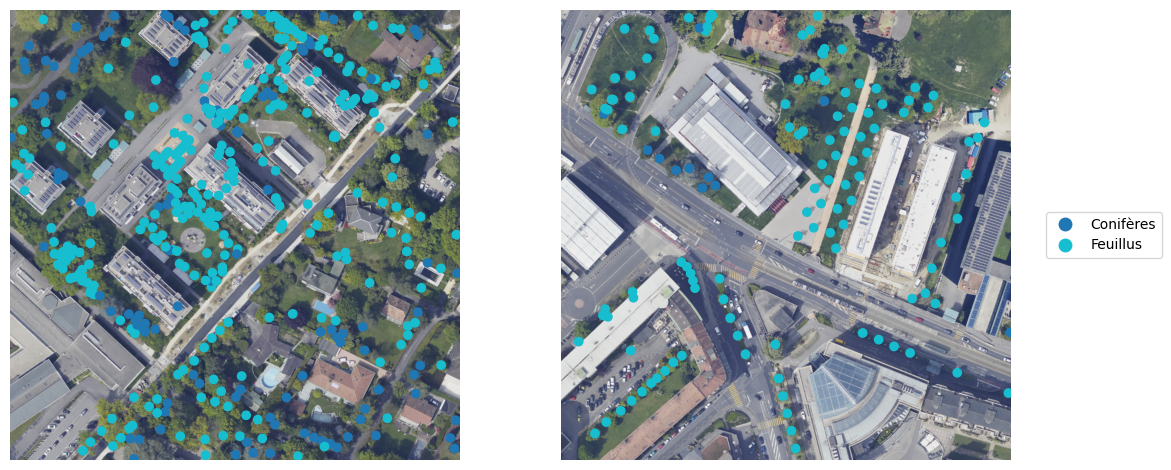

In [ ]:
img_filenames = split_df[split_df["train"]]["img_filename"]
fig, axes = plt.subplots(
    1,
    len(img_filenames),
    figsize=(figwidth * len(img_filenames), figheight),
)
for img_filename, ax, legend in zip(
    img_filenames, axes, [False] * (len(img_filenames) - 1) + [True]
):
    plot_tile_and_trees(
        ax,
        path.join(tile_dir, img_filename),
        trees_gdf,
        column="CLASSE",
        legend=legend,
        legend_kwds={"loc": "center right", "bbox_to_anchor": (1.35, 0.5)},
    )
fig.tight_layout()

We can see two issues with the cantonal tree inventory. First, the annotations are point locations rather than bounding boxes, which is less convenient for deep learning models since trees tend to vary in size. Secondly, there are some mismatches between the point annotations and what we see in the image. Therefore, despite its cost, it is better to provide manual bounding box annotations, e.g., using [Label Studio](https://labelstud.io).

Despite the dominance of deciduous (feuillus in French) trees, it seems that there is a fair occurrence of both tree groups in the training tiles. Otherwise we could perform a spatial join of the tiles and tree annotations to select tiles ensuring a minimum occurrence, e.g.:

In [ ]:
tiles_gdf.sjoin(trees_gdf, how="inner", predicate="contains").groupby("tile_filename")[
    "CLASSE"
].value_counts().unstack().fillna(0).apply(
    lambda col_ser: col_ser.astype(int), axis="index"
)

CLASSE,Conifères,Feuillus
tile_filename,,
2497474.7_1116843.6_2497724.7_1117093.6.tif,49,28
2497474.7_1117093.6_2497724.7_1117343.6.tif,68,75
2497474.7_1117343.6_2497724.7_1117593.6.tif,15,11
2497474.7_1117593.6_2497724.7_1117843.6.tif,5,42
2497474.7_1117843.6_2497724.7_1118093.6.tif,25,122
...,...,...
2502224.7_1118093.6_2502474.7_1118343.6.tif,20,99
2502224.7_1118343.6_2502474.7_1118593.6.tif,60,90
2502224.7_1118593.6_2502474.7_1118843.6.tif,4,18


But for now, let us use the above train/test split for the initial fine-tuning of the pre-trained model. We can later use more advanced active learning criteria to select the next batch of training tiles. Let us then dump the split to a file and proceed in a separate notebook.

In [ ]:
split_df.to_csv(dst_filepath, index=False)